## Tidal Debris from M33

1. change the mass of sat, select star from the previous Rj.

In [36]:
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from ReadFile import Read

# edit CenterOfMass2 to Calculate COM of all components 
from CenterOfMass2 import CenterOfMass
# edit GalaxyMAss to Calculate Mass of all components 
from GalaxyMass import ComponentMass


In [37]:
def Mass_enclose(filename,radius,COMP):
# function to compute the mass of all particles less than the distance between two Galaxy COM position 
# Inputs:
#       filename: galaxyfile for input
#       radius: COM position difference in kpc
#       COMP: COM positon of each galaxy [x, y, z]
#       output: Mass in units of Msun. 
    
    # read in the file 
    time, total, data = Read(filename)
    
    # gather particles with the same type and sum up the mass
    mass = np.round(data[np.sqrt((data['x']-COMP[0])**2+(data['y']-COMP[1])**2+(data['z']-COMP[2])**2) < radius]['m'].sum() * 1e10, 3)
    
    # return the mass 
    return mass


In [38]:
def Select_tides_star(M33,Rj_MW_M33,Rj_M31_M33,COMP_M33):
    """Select tides star of M33"""
    # Inputs:
    #      M33: each snap file name of M33
    #      Rj_MW_M33: Jacobi Radius of MW and M33 system
    #      Rj_M1_M33: Jacobi Radius of M31 and M33 system
    #      COMP_M33: COM positon of M33 [x, y, z]
    # Outpur:
    #      tidal_star list
    time, total, data = Read(M33)
    MW_index = np.where(np.sqrt((data['x']-COMP_M33[0])**2+(data['y']-COMP_M33[1])**2+(data['z']-COMP_M33[2])**2) >= Rj_MW_M33)
    M31_index = np.where(np.sqrt((data['x']-COMP_M33[0])**2+(data['y']-COMP_M33[1])**2+(data['z']-COMP_M33[2])**2) >= Rj_M31_M33)
    total_index = M31_index
    for i in range(len(MW_index)):
        if MW_index[i] not in total_index:
            total_index = np.append(total_index,MW_index[i])
    
    tidal_star_MW = data[MW_index]
    tidal_star_M31 = data[M31_index]
    tidal_star_total = data[total_index]
    
    return tidal_star_MW, tidal_star_M31, tidal_star_total

In [40]:
class Snap:
    """This is a class for each Snap with M31, MW, M33"""
    
    def __init__(self,Snap_number):
        # get the snap file name of MW M31 and M33
        # Inputs: Snapnumber
        # self.time unit is Myr
        
        self.Snap_number = Snap_number
        self.MWfilename = "VLowRes/" + 'MW' + "_VLowRes/" + 'MW' +  "_{:03d}".format(self.Snap_number) + ".txt"
        self.M31filename = "VLowRes/" + 'M31' + "_VLowRes/" + 'M31' +  "_{:03d}".format(self.Snap_number) + ".txt"
        self.M33filename = "VLowRes/" + 'M33' + "_VLowRes/" + 'M33' +  "_{:03d}".format(self.Snap_number) + ".txt"
        self.time = Snap_number*10/0.7
    
    def COM(self):
        # Calculate the COM Position of MW, M31 and M33 
        
        MW_COM = CenterOfMass(self.MWfilename)
        M31_COM = CenterOfMass(self.M31filename)
        M33_COM = CenterOfMass(self.M31filename)
        
        # For MW and M31 delta = 0.1 and VelDec = 2
        # For M33 dalta = 0.1 and VelDec = 4
        
        COMP_MW = MW_COM.COM_P(0.1,2)
        COMP_M31 = M31_COM.COM_P(0.1,2)
        COMP_M33 = M33_COM.COM_P(0.1,4)
        self.COMP_MW = COMP_MW.value
        self.COMP_M31 = COMP_M31.value
        self.COMP_M33 = COMP_M33.value
        
        return self.COMP_MW, self.COMP_M31, self.COMP_M33
    
    
    def COMdiff(self,galaxy1,galaxy2):
        # Calculate the COM Position distance of two Galaxy
        
        COMdiff = np.sqrt((galaxy1[0]-galaxy2[0])**2+(galaxy1[1]-galaxy2[1])**2+(galaxy1[2]-galaxy2[2])**2)        
        
        return COMdiff
    
    def Total_Mass(self,galaxy_name):
        # Calculate total Mass of each Galaxy 
        
        return ComponentMass(galaxy_name) 
    
    def Mass_enclose(self,PreRjMW_M33,PreRjMW_M31):
        # Calculate the Mass enclose less than the distance between two Galaxy COM Position
        
        #Calculate COM Positoon
        self.COMP_MW, self.COMP_M31, self.COMP_M33 = self.COM()
        
        #Calculate MW_M33 M31_M33 COMP difference
        self.MW_M33diff = self.COMdiff(self.COMP_MW,self.COMP_M33)
        self.M31_M33diff = self.COMdiff(self.COMP_M31,self.COMP_M33)
        
        #Calculate the mass inclose
        self.MW_enclose = Mass_enclose(self.MWfilename, self.MW_M33diff,self.COMP_MW)
        self.M31_enclose = Mass_enclose(self.M31filename, self.M31_M33diff,self.COMP_M31)
        self.M33_enclose_MW = Mass_enclose(self.M33filename, PreRjMW_M33,self.COMP_M33)
        self.M33_enclose_M31 = Mass_enclose(self.M33filename, PreRjMW_M31,self.COMP_M33)
        
        return self.M31_enclose, self.MW_enclose, self.M33_enclose_MW, self.M33_enclose_M31
    
    def Rj(self,PreRjMW_M33=10000,PreRjMW_M31=10000):
        # Calculate the Jacobi Radius of M31-M33 and MW-M33 system
        # Rj = r*(Msat/Mhost(<r))**(1/3)
        # Msat is M33, Mhost is enclose mass of MW and M31
        self.MWmass = self.Total_Mass(self.MWfilename)
        self.M31mass = self.Total_Mass(self.M31filename)
        self.M33mass = self.Total_Mass(self.M33filename)
        
        self.COMP_MW, self.COMP_M31, self.COMP_M33 = self.COM()
        
        self.MW_M33diff = self.COMdiff(self.COMP_MW,self.COMP_M33)
        self.M31_M33diff = self.COMdiff(self.COMP_M31,self.COMP_M33)
        
        self.M31_enclose, self.MW_enclose, self.M33_enclose_MW, self.M33_enclose_M31= self.Mass_enclose(PreRjMW_M33,PreRjMW_M31)
        
        self.Rj_MW_M33 = self.MW_M33diff *(self.M33_enclose_MW/self.MW_enclose)**(1/3)
        self.Rj_M31_M33 = self.M31_M33diff *(self.M33_enclose_M31/self.M31_enclose)**(1/3)
        
        return self.Rj_MW_M33, self.Rj_M31_M33
    
    def select_star(self):
        
        self.Rj_MW_M33, self.Rj_M31_M33 = self.Rj()
        
        self.tidal_star_MW, self.tidal_star_M31, self.tidal_star_total = Select_tides_star(self.M33filename,self.Rj_MW_M33,self.Rj_M31_M33,self.COMP_M33)
        
        return self.tidal_star_MW, self.tidal_star_M31, self.tidal_star_total


In [59]:
t = Snap(1)

In [60]:
t.COM()

(array([-2.04,  3.12, -1.49]),
 array([-376.07,  609.98, -283.97]),
 array([-376.17,  610.11, -283.89]))

In [28]:
np.sqrt((-293.22-(-281.11))**2 + (505.09-501.26)**2 +(-215-(-211.09))**2)

13.289435653932042

In [29]:
t.Mass_enclose(10000,10000)

(80708083740.0, 1724423737999.999, 195913000000.0, 195913000000.0)

In [61]:
a,b = t.Rj()

In [63]:
a,b

(366.77148899551594, 1.444741393735398)

In [32]:
starMW = []
starM31 = []
starT = []
starMW,starM31,starT = t.select_star()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


In [33]:
len(starMW)

682

In [34]:
len(starM31)

14300

In [35]:
len(starT)

14982

In [62]:
starMW

array([(1., 0.00373226,  6.83653e+02,  2.29640e+03, -3.54354e+02,   40.6226  ,  9.61086e+01, 139.611  ),
       (1., 0.00373226, -2.62424e+02,  7.93488e+02, -5.97544e+02,   26.5387  ,  4.50087e+01, 191.095  ),
       (1., 0.00373226, -1.64494e+02,  8.20262e+02, -4.05828e+02,   34.4837  ,  2.97120e+01, 211.802  ),
       (1., 0.00373226, -3.84501e+01,  6.88735e+02, -2.02983e+02,  -29.6997  ,  4.33915e+01, 197.602  ),
       (1., 0.00373226,  9.92978e+01,  6.46916e+02,  1.90658e+02,    9.28519 ,  7.04353e+01, 109.076  ),
       (1., 0.00373226, -1.21197e+03,  1.06697e+03, -3.28748e+02,   57.4902  ,  9.32989e+01, 142.081  ),
       (1., 0.00373226, -7.22843e+01,  7.14133e+02, -3.66019e+02,   22.7158  ,  5.90773e+01, 172.28   ),
       (1., 0.00373226, -2.75159e+02,  6.19999e+02, -5.09058e+02,   69.3152  ,  7.95585e+01, 189.682  ),
       (1., 0.00373226, -1.27960e+03,  7.47316e+01, -7.24678e+02,   53.8462  ,  1.04984e+02, 145.262  ),
       (1., 0.00373226, -5.53770e+02,  9.13253e+02, -2.

In [77]:
from tqdm import tqdm
snap_id = []
Rj_MW_M33 = []
Rj_M31_M33 = []
j = 0
for i in tqdm(range(1,101,5)):
    temp_snap = Snap(i)
    if i == 1:
        temp_Rj_MW_M33, temp_Rj_M31_M33 = temp_snap.Rj()
        Rj_MW_M33.append(temp_Rj_MW_M33)
        Rj_M31_M33.append(temp_Rj_M31_M33)
    else:
        temp_Rj_MW_M33, temp_Rj_M31_M33 = temp_snap.Rj(Rj_MW_M33[j],Rj_M31_M33[j])
        Rj_MW_M33.append(temp_Rj_MW_M33)
        Rj_M31_M33.append(temp_Rj_M31_M33)
        j += 1
    snap_id.append(i)



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:15<04:46, 15.08s/it]

 10%|█         | 2/20 [00:30<04:34, 15.27s/it]

 15%|█▌        | 3/20 [00:45<04:17, 15.14s/it]

 20%|██        | 4/20 [01:01<04:05, 15.35s/it]

 25%|██▌       | 5/20 [01:14<03:38, 14.57s/it]

 30%|███       | 6/20 [01:27<03:20, 14.32s/it]

 35%|███▌      | 7/20 [01:40<03:00, 13.91s/it]

 40%|████      | 8/20 [01:53<02:42, 13.55s/it]

 45%|████▌     | 9/20 [02:07<02:29, 13.62s/it]

 50%|█████     | 10/20 [02:19<02:12, 13.22s/it]

 55%|█████▌    | 11/20 [02:33<02:01, 13.46s/it]

 60%|██████    | 12/20 [02:46<01:46, 13.28s/it]

 65%|██████▌   | 13/20 [02:58<01:30, 12.88s/it]

 70%|███████   | 14/20 [03:11<01:17, 12.84s/it]

 75%|███████▌  | 15/20 [03:22<01:02, 12.47s/it]

 80%|████████  | 16/20 [03:33<00:48, 12.06s/it]

 85%|████████▌ | 17/20 [03:45<00:35, 11.77s/it]

 90%|█████████ | 18/20 [03:56<00:23, 11.57s/it]

 95%|█████████▌| 19/20 [04:07<00:11, 11.50s/it]

100%|██████████| 20/20 [04:18<00:00,

In [78]:
Rj_MW_M33

[366.77148899551594,
 345.7408761721368,
 342.61742181606814,
 339.25183176205906,
 335.7392159922693,
 330.83364404893825,
 327.5658975856285,
 325.18667745180073,
 320.7859036721584,
 316.6476503625817,
 312.8659024130138,
 308.2536081533759,
 305.3511699940214,
 301.8069899262213,
 298.98708076712285,
 294.9228545047138,
 291.3782887635562,
 282.8273441957278,
 285.2007879654345,
 276.47588606868595]

In [79]:
Rj_M31_M33

[1.444741393735398,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [74]:
from tqdm import tqdm
snap_id = []
Rj_MW_M33 = []
Rj_M31_M33 = []
j = 0
for i in tqdm(range(1,801,50)):
    temp_snap = Snap(i)
    temp_Rj_MW_M33, temp_Rj_M31_M33 = temp_snap.Rj()
    Rj_MW_M33.append(temp_Rj_MW_M33)
    Rj_M31_M33.append(temp_Rj_M31_M33)
    snap_id.append(i)



  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:13<03:17, 13.16s/it]

 12%|█▎        | 2/16 [00:28<03:13, 13.81s/it]

 19%|█▉        | 3/16 [00:42<02:58, 13.75s/it]

 25%|██▌       | 4/16 [00:54<02:39, 13.25s/it]

 31%|███▏      | 5/16 [01:10<02:36, 14.26s/it]

 38%|███▊      | 6/16 [01:27<02:29, 14.96s/it]

 44%|████▍     | 7/16 [01:40<02:10, 14.52s/it]

 50%|█████     | 8/16 [01:55<01:57, 14.66s/it]

 56%|█████▋    | 9/16 [02:11<01:43, 14.81s/it]

 62%|██████▎   | 10/16 [02:23<01:24, 14.15s/it]

 69%|██████▉   | 11/16 [02:38<01:11, 14.35s/it]

 75%|███████▌  | 12/16 [02:52<00:56, 14.23s/it]

 81%|████████▏ | 13/16 [03:04<00:40, 13.64s/it]

 88%|████████▊ | 14/16 [03:16<00:26, 13.19s/it]

 94%|█████████▍| 15/16 [03:28<00:12, 12.78s/it]

100%|██████████| 16/16 [03:41<00:00, 13.85s/it]


In [75]:
Rj_MW_M33

[366.77148899551594,
 327.81804881752123,
 290.2415330764903,
 241.82402402571256,
 177.7078067251049,
 88.82856666192873,
 72.03280209133852,
 96.85638214303657,
 42.01384935082548,
 1.765910622978336,
 69.27935584420204,
 2.1583840804921635,
 2.657056648976282,
 2.094637464846342,
 2.106615931308577,
 2.1233732816527944]

In [76]:
Rj_M31_M33

[1.444741393735398,
 2.9141331756552686,
 1.6946695990691067,
 1.948570823330607,
 1.563196483267721,
 1.3626882534180713,
 4.558666519996171,
 1.8185636009980304,
 2.2617761669747782,
 2.6619555920340425,
 2.681858072801591,
 4.8068297018396615,
 3.639987144774505,
 2.680451505526067,
 2.9142752847147526,
 2.8210647554964075]

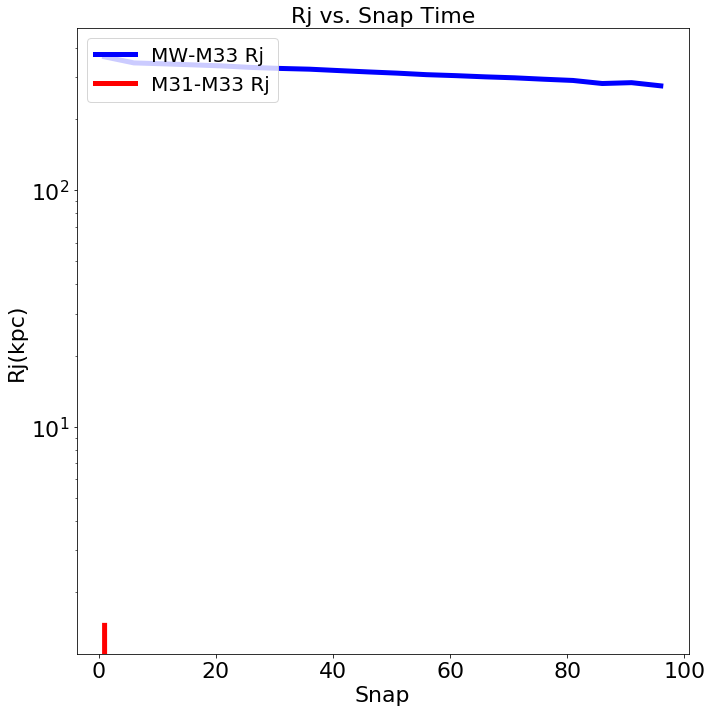

In [70]:
fig, ax= plt.subplots(figsize=(10, 10))

# Plot the analytical separation of M31 and M33
ax.semilogy(snap_id, Rj_MW_M33, 'b', lw=5, label='MW-M33 Rj')

# Plot the simulated separation of M31 and M33
ax.semilogy(snap_id, Rj_M31_M33, 'r', lw=5, label='M31-M33 Rj')


# Add axis labels
ax.set_xlabel('Snap', fontsize=22)
ax.set_ylabel('Rj(kpc)', fontsize=22)
ax.set_title("Rj vs. Snap Time", fontsize=22)

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize=20)

# tight layout
fig.tight_layout()

# Save to a file
fig.savefig('orbit_M33_R.pdf')

In [71]:
Rj_M31_M33

[1.444741393735398,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [64]:
snap_id

[1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751]

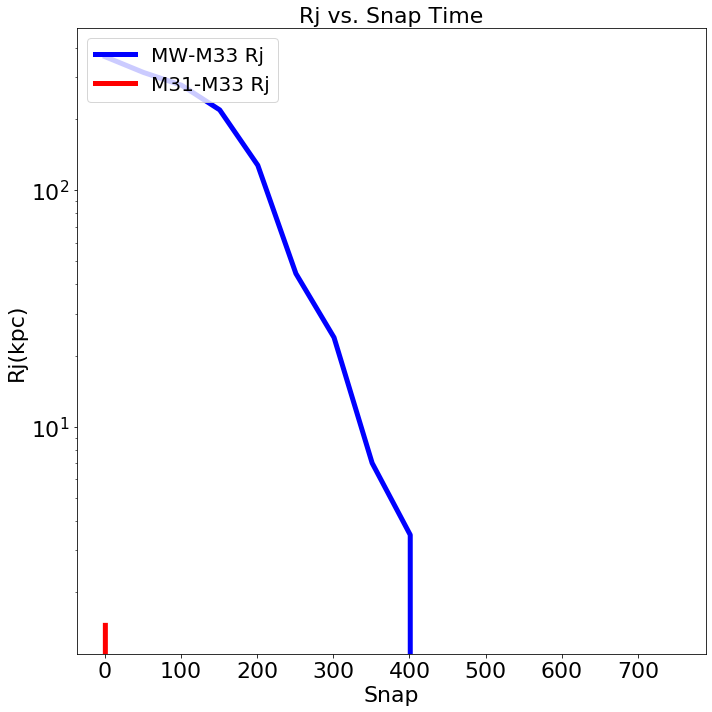

In [65]:
fig, ax= plt.subplots(figsize=(10, 10))

# Plot the analytical separation of M31 and M33
ax.semilogy(snap_id, Rj_MW_M33, 'b', lw=5, label='MW-M33 Rj')

# Plot the simulated separation of M31 and M33
ax.semilogy(snap_id, Rj_M31_M33, 'r', lw=5, label='M31-M33 Rj')


# Add axis labels
ax.set_xlabel('Snap', fontsize=22)
ax.set_ylabel('Rj(kpc)', fontsize=22)
ax.set_title("Rj vs. Snap Time", fontsize=22)

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize=20)

# tight layout
fig.tight_layout()



In [94]:
t.Rj()

(1.6734396454618228, 292.15500313251613)

In [10]:
mu0 = 4*np.pi*1e-7
q = 1.609*1e-19
g = 9.81
y = 0.01
m = 9.11*1e-31

In [11]:
((mu0*q**2)/(6*np.pi*3*1e8*m))*np.sqrt((2*1.8676*1e12)/y)

1.220500967189043e-16